In [31]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import control.matlab
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from examples.RLC.symbolic_RLC import fxu_ODE, fxu_ODE_nl

![RLC circuit](../doc/RLC_circuit.png)

In [32]:
def saturation_formula(current_abs):
    sat_ratio = (1/np.pi*np.arctan(-1.0*(np.abs(current_abs)-5))+0.5)*0.9 + 0.1
    return sat_ratio

def saturation_formula_paper(current_abs): #! TYPO in paper
    sat_ratio = 0.9/np.pi * np.arctan(-5.0*np.abs(current_abs)-5)+0.5+0.1
    return sat_ratio

In [33]:
saturation_formula(0), saturation_formula_paper(0)

(0.9434503376298989, 0.20654966237010106)

Text(0, 0.5, 'Inductance $L$ ($\\mu$H)')

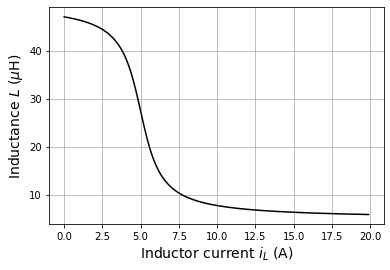

In [34]:
L_0nom = 50e-6 # 50 µH
inductor_current = np.arange(0., 20., 0.1)
plt.plot(inductor_current, L_0nom * 1e6 * saturation_formula(inductor_current), 'k')
plt.grid()
plt.xlabel('Inductor current $i_L$ (A)', fontsize=14)
plt.ylabel('Inductance $L$ ($\mu$H)', fontsize=14)

In [35]:
# Input characteristics #
len_sim = 5e-3 # milliseconds
Ts = 1e-6  # 1 µs
omega_input = 80e3 # 80 kHz # bandwidth of the filter
tau_input = 1 / omega_input
std_input = 80 # V

seed = 1
rng = np.random.default_rng(seed=seed)

##### Input description according to paper:
The input is a filtered white noise with bandwidth 80, 90, 100, 100 kHz and standard deviation 80, 70, 70, 70 V for the training, test, transfer, and evaluation datasets, respectively. In the training and transfer datasets, the output v_C is corrupted by an
additive white noise term.

In [36]:
# white noise is a random process
# white noise has all frequencies -> not possible -> need filter
# input transfer function -> this is the filter used to filter the white noise
Hu = control.TransferFunction([1], [1 / omega_input, 1])
Hu

TransferFunction(array([1]), array([1.25e-05, 1.00e+00]))

In [37]:
Hu = Hu*Hu
Hu

TransferFunction(array([1.]), array([1.5625e-10, 2.5000e-05, 1.0000e+00]))

In [38]:
# discretize the filter < through this filter the random process is passed
Hud = control.matlab.c2d(Hu, Ts)
Hud

TransferFunction(array([0.00303435, 0.00287675]), array([ 1.        , -1.84623269,  0.85214379]), 1e-06)

Text(0.5, 1.0, 'example input (unfiltered)')

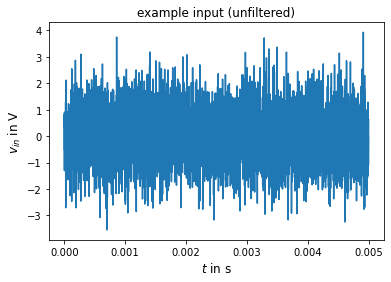

In [39]:
# generate the white noise 
#? do not use the 'initial skip samples'
N_sim = int(len_sim // Ts)
e = rng.standard_normal(N_sim)
te = np.arange(N_sim) * Ts
plt.plot(te, e)
plt.ylabel(r'$v_{in}$ in V', fontsize=12)
plt.xlabel(r'$t$ in s', fontsize=12)
plt.title('example input (unfiltered)')

In [40]:
# filter the white noise (-> colored noise)
_, u = control.forced_response(Hu, te, e, return_x=False)

Text(0.5, 1.0, 'example input (filtered, but still unscaled)')

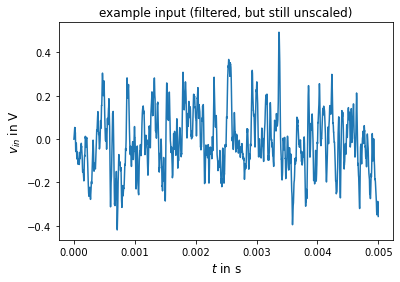

In [41]:
plt.plot(te, u)
plt.ylabel(r'$v_{in}$ in V', fontsize=12)
plt.xlabel(r'$t$ in s', fontsize=12)
plt.title('example input (filtered, but still unscaled)')

Text(0.5, 1.0, 'example input (filtered and scaled)')

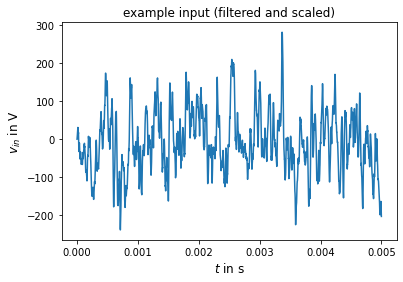

In [42]:
# scaled input signal
u = u / np.std(u) * std_input
plt.plot(te, u)
plt.ylabel(r'$v_{in}$ in V', fontsize=12)
plt.xlabel(r'$t$ in s', fontsize=12)
plt.title('example input (filtered and scaled)')

#### Now: simulate the system with the generated (random) input signal

Output of the system: capacitor voltage v_C and inductor current i_L

In [43]:
t_sim = np.arange(N_sim) * Ts
u_func = interp1d(t_sim, u, kind='zero', fill_value="extrapolate")

def f_ODE(t, x):
    u = u_func(t).ravel()
    return fxu_ODE(t, x, u)
    
def f_ODE_nl(t, x):
    u = u_func(t).ravel()
    return fxu_ODE_nl(t, x, u)

In [44]:
# initial conditions 
x0 = np.zeros(2)
f_ODE(0.0, x0), f_ODE_nl(0.0, x0)

(array([0., 0.]), array([0., 0.]))

In [45]:
# Simulate Linear and Non-Linear
t_span = (t_sim[0], t_sim[-1])
y_lin = solve_ivp(f_ODE, t_span, x0, t_eval=t_sim)  # Linear
y_nonlin = solve_ivp(f_ODE_nl, t_span, x0, t_eval=t_sim)  # Non-Linear

In [46]:
# System states over time
# System State x = [v_c, i_l].T
x_lin = y_lin.y
x_nonlin = y_nonlin.y
x_lin.shape, x_nonlin.shape

((2, 5000), (2, 5000))

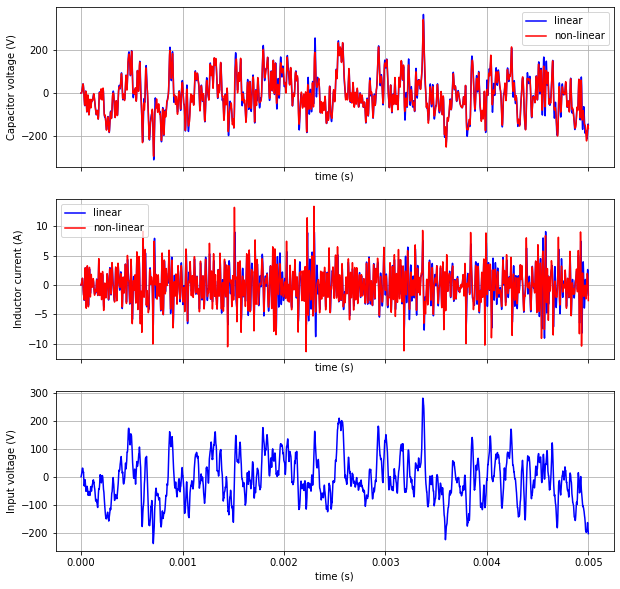

In [47]:
# plot the outputs
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].plot(t_sim, x_lin[0,:], 'b', label='linear')  # Linear
ax[0].plot(t_sim, x_nonlin[0, :], 'r', label='non-linear')  # Non-Linear
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Capacitor voltage (V)')
ax[0].legend()

ax[1].plot(t_sim, x_lin[1, :], 'b', label='linear')
ax[1].plot(t_sim, x_nonlin[1, :], 'r', label='non-linear')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Inductor current (A)')
ax[1].legend()

ax[2].plot(t_sim, u, 'b')
ax[2].set_xlabel('time (s)')
ax[2].set_ylabel('Input voltage (V)')
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
plt.show()

In [48]:
scale_x = [90., 3.]
scale_u = std_input

In [49]:
x_lin = (x_lin.T / scale_x).T
x_nonlin = (x_nonlin.T / scale_x).T
u = u / scale_u

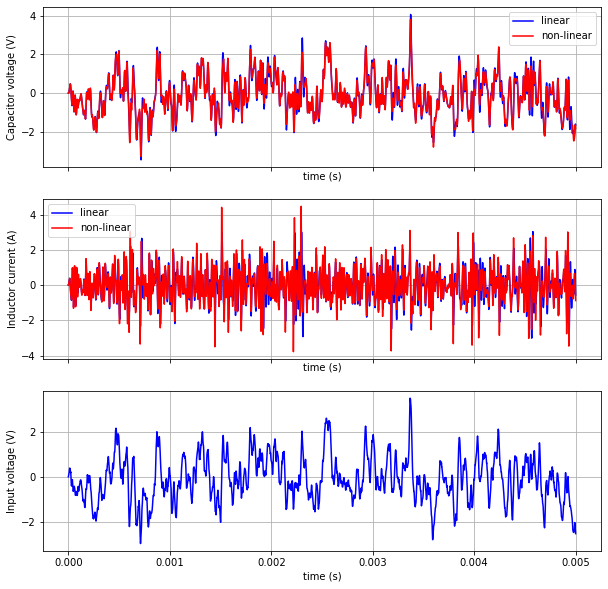

In [50]:
# plot the outputs
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].plot(t_sim, x_lin[0,:], 'b', label='linear')  # Linear
ax[0].plot(t_sim, x_nonlin[0, :], 'r', label='non-linear')  # Non-Linear
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Capacitor voltage (V)')
ax[0].legend()

ax[1].plot(t_sim, x_lin[1, :], 'b', label='linear')
ax[1].plot(t_sim, x_nonlin[1, :], 'r', label='non-linear')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Inductor current (A)')
ax[1].legend()

ax[2].plot(t_sim, u, 'b')
ax[2].set_xlabel('time (s)')
ax[2].set_ylabel('Input voltage (V)')
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

In [51]:
x = 1 if False else 2
x

2

### Tasks:

How do we frame the 'prediction' problem?
In the paper they learn the state equation, i.e. they predict the state derivative (x dot). Model is discretized with Euler forward. 

Tasks are: 
- Parameter variations

Prediction problem:
Use RNN:
- inputs last 25 timesteps
- predict delta of ground truth of last input to the next input
